In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.images as images
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y], dtype=np.double)
LI = plotutil.LensInfo
DI = plotutil.DensInfo

feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

In [2]:
# This is a helper routine to create a 3D plot of the density of a lens, as well as
# critical lines and caustics for Dds/Ds = 0.8
def createPlots(lens, s):
    lensInfo = LI(lens=lens, size=s, Ds=1.0, Dds=0.8) 

    plotutil.plotDensityInteractive(lensInfo)
    plt.figure(figsize=(8,8))
    plotutil.plotImagePlane(lensInfo)
    return lensInfo

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

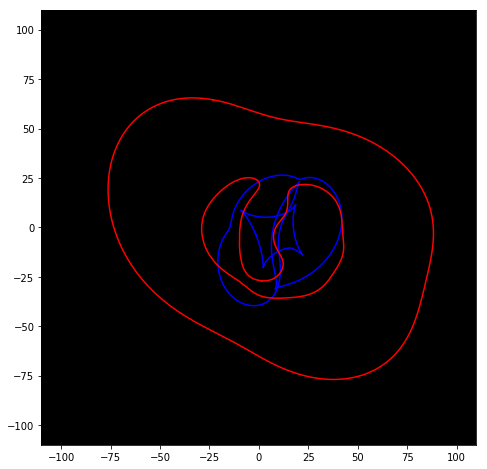

In [3]:
# First we're going to load an actual lens model and visualize it in some plots. In
# a next step, we'll obtain the deflection angles of this lens at evenly spaced points
# which we'll use to create a DeflectionGridLens instance
realLens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
size = 220*ANGLE_ARCSEC

lensInfoReal = createPlots(realLens, size)

In [4]:
# Here we'll store the deflection angles of this real lens model in a
# 512x512 grid. 
deflectionAngles = np.zeros((512,512,2))
tr, bl = lensInfoReal.getTopRight(), lensInfoReal.getBottomLeft()


# The bottom left corner will correspond with the deflection angle
# at the 0,0 position; the top right corner corresponds with the
# other extreme. The 'div' variable below will contain the spacing
# in each direction; to calculate it we must to a -1 for the grid
# shapes to make sure that point 511,511 will correspond exactly to
# the topright point
div = V(deflectionAngles.shape[1]-1, deflectionAngles.shape[0]-1)
for y in range(deflectionAngles.shape[0]):
    for x in range(deflectionAngles.shape[1]):
        # Calculate the image plane position (theta) that corresponds
        # to the grid position, based on the bottom left and top tight
        # coordinates
        theta = (tr-bl)/div * V(x,y) + bl
       
        # Get the real deflection angle at that point, and store it in
        # our grid
        deflectionAngles[y,x,:] = realLens.getAlphaVector(theta)

# Note that this is explicit method is rather slow, a faster way to
# do this would be this:
#
#    thetas = np.zeros(deflectionAngles.shape)
#   
#    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bl[0],tr[0], thetas.shape[1]),
#                                               np.linspace(bl[1],tr[1], thetas.shape[0]))
#    deflectionAngles = realLens.getAlphaVector(thetas)

In [5]:
# With this grid, we can now create a DeflectionGridLens. When the deflection
# angle is queried precisely at one of the stored points, then that will be
# retrieved. For other positions, each component of the deflection angle will
# be bi-linearly interpolated

Dd = realLens.getLensDistance()
dgLens = lenses.DeflectionGridLens(Dd, {
    'angles': deflectionAngles,
    'bottomleft': bl,
    'topright': tr
})

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

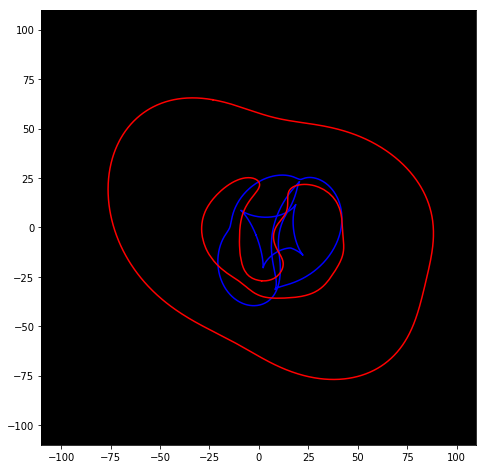

In [6]:
# Let's create some plots for this lens as well. They should look nearly identical
# to the plots above
lensInfoDG = createPlots(dgLens, size)

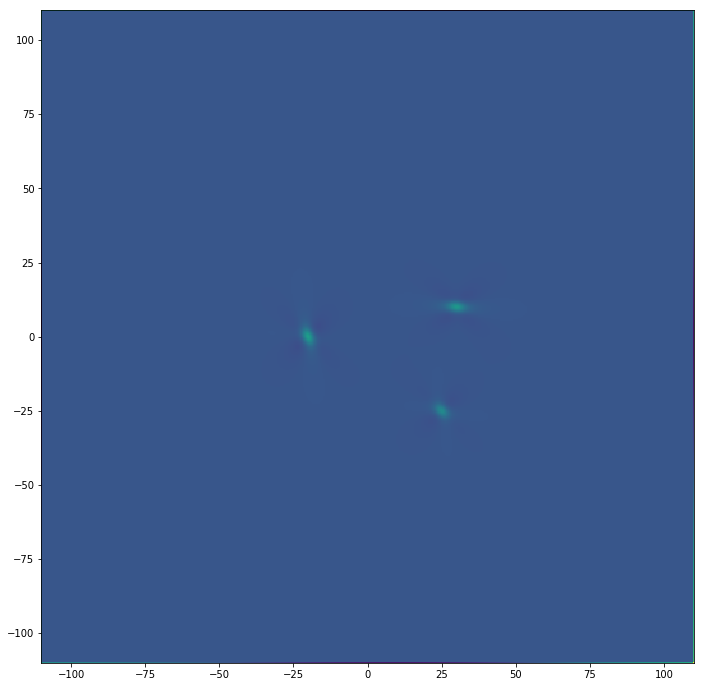

In [7]:
# To show that they're not really identical, let's plot the difference between
# the densities that were calculated
densDiff = lensInfoReal.getDensityPoints() - lensInfoDG.getDensityPoints()
densInfo = DI(densDiff, **lensInfoReal.getArea())

plt.figure(figsize=(12,12))
plotutil.plotDensity(densInfo)

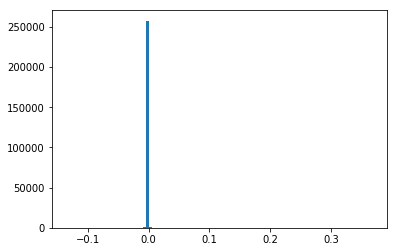

In [8]:
# And if we show a histogram of the differences, it's clear that the difference will
# be very low, but not exactly zero
plt.hist(densDiff.reshape(densDiff.shape[0]*densDiff.shape[1]), bins=100);

In [9]:
# Based on the deflections, and approximation is created for the lensing potential as
# well. This allows you to calculate the time delays for example, but since the deflection
# angles are only the derivatives of the potential, the deviations in the potential
# and therefore the time delays can be larger.

# Here we choose 10 points in the source plane, trace them to the image plane, and
# calculate the time delays. This is done for both the real lens and the approximation.
count = 10
z_lens = 0.4
year = 60*60*24*365
while count > 0:
    
    beta = np.random.uniform([-30,-30],[30,30])*ANGLE_ARCSEC
    thetaReal = np.array(lensInfoReal.getImagePlane().traceBeta(beta))
    thetaApprox = np.array(lensInfoDG.getImagePlane().traceBeta(beta))
    if len(thetaReal) < 2:
        continue
    
    count -= 1

    tdReal = realLens.getTimeDelay(z_lens,1.0,0.8,thetaReal,beta)
    tdApprox = dgLens.getTimeDelay(z_lens,1.0,0.8,thetaApprox,beta)
    tdReal -= tdReal[0]
    tdApprox -= tdApprox[0]

    beta /= ANGLE_ARCSEC
    thetaReal /= ANGLE_ARCSEC
    thetaApprox /= ANGLE_ARCSEC
    tdReal /= year
    tdApprox /= year
    print(f"beta = ({beta[0]:9.5g},{beta[0]:9.5g})")
    for i in range(len(thetaReal)):
        print(f" theta_real = ({thetaReal[i,0]:9.5g},{thetaReal[i,1]:9.5g}): {tdReal[i]:9.7g} years |" + 
              f" theta_approx = ({thetaApprox[i,0]:9.5g},{thetaApprox[i,1]:9.5g}): {tdApprox[i]:9.7g} years")
        

Text(value='')

Text(value='')

Text(value='')

Text(value='')

beta = (    14.64,    14.64)
 theta_real = (   30.461,  -63.431):         0 years | theta_approx = (    30.46,  -63.431):         0 years
 theta_real = (  -37.933,   -51.84): -19.47103 years | theta_approx = (  -37.931,  -51.841): -18.36329 years
 theta_real = (  -61.841,  -9.1509): -12.43275 years | theta_approx = (   -61.84,  -9.1518): -11.81763 years
 theta_real = (  -16.642,  -2.7272):  99.68434 years | theta_approx = (  -16.637,  -2.7302):  99.63737 years
 theta_real = (   52.006,   73.901): -291.6285 years | theta_approx = (   52.006,   73.901): -293.8208 years


Text(value='')

Text(value='')

beta = (   26.321,   26.321)
 theta_real = (  -28.393,  -31.368):         0 years | theta_approx = (  -28.392,  -31.367):         0 years
 theta_real = (  -19.079,   -8.282):  12.87563 years | theta_approx = (  -19.079,  -8.2888):  12.24475 years
 theta_real = (   67.587,   83.857):  -691.626 years | theta_approx = (   67.587,   83.857): -694.7217 years


Text(value='')

Text(value='')

beta = (    18.41,    18.41)
 theta_real = (   8.8936,  -45.528):         0 years | theta_approx = (   8.8935,  -45.526):         0 years
 theta_real = (   15.243,  -28.613):  4.863515 years | theta_approx = (    15.24,  -28.614):   4.54383 years
 theta_real = (    50.58,   90.634): -645.1478 years | theta_approx = (    50.58,   90.634): -647.6644 years


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

beta = (   10.685,   10.685)
 theta_real = (  -34.944,  -64.944):         0 years | theta_approx = (  -34.944,  -64.944):         0 years
 theta_real = (   56.693,  -53.885):  65.38522 years | theta_approx = (   56.692,  -53.885):  63.81889 years
 theta_real = (  -15.712, -0.71992):   200.464 years | theta_approx = (  -15.709, -0.72035):  199.1959 years
 theta_real = (  -57.279,   26.193):  76.88434 years | theta_approx = (  -57.278,   26.193):  75.49075 years
 theta_real = (   48.331,   66.375): -64.04004 years | theta_approx = (   48.331,   66.375): -67.32609 years


Text(value='')

Text(value='')

beta = (    19.05,    19.05)
 theta_real = (  -18.914,  0.97775):         0 years | theta_approx = (   -18.91,  0.98009):         0 years
 theta_real = (  -48.521,   22.113): -61.25685 years | theta_approx = (  -48.521,   22.112): -61.38295 years
 theta_real = (   82.438,   37.221): -329.0794 years | theta_approx = (   82.438,   37.221): -331.1489 years


Text(value='')

Text(value='')

beta = (   17.179,   17.179)
 theta_real = (   3.0132,  -70.044):         0 years | theta_approx = (   3.0164,  -70.044):         0 years
 theta_real = (   16.372,  -70.058):     0.163 years | theta_approx = (   16.369,  -70.058): -0.05043014 years
 theta_real = (  -17.922,   -1.456):  148.7514 years | theta_approx = (  -17.919,  -1.4575):  148.1445 years
 theta_real = (  -59.254,   5.9339):  54.14337 years | theta_approx = (  -59.254,   5.9335):  53.80513 years
 theta_real = (   62.033,   66.336): -234.5339 years | theta_approx = (   62.033,   66.335):  -237.334 years


Text(value='')

Text(value='')

beta = (   18.228,   18.228)
 theta_real = (   12.301,  -98.487):         0 years | theta_approx = (   12.301,  -98.487):         0 years
 theta_real = (  -19.477,   11.216):  535.8013 years | theta_approx = (  -19.477,   11.225):  534.9622 years
 theta_real = (  -24.296,    22.32):  534.1059 years | theta_approx = (  -24.294,   22.318):  533.1323 years


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

beta = (   11.694,   11.694)
 theta_real = (   30.766,  -55.473):         0 years | theta_approx = (   30.765,  -55.472):         0 years
 theta_real = (   21.438,  -23.758):  43.17156 years | theta_approx = (   21.431,  -23.756):  42.99387 years
 theta_real = (   39.683,   83.633):  -418.703 years | theta_approx = (   39.683,   83.633): -420.7159 years


Text(value='')

Text(value='')

Text(value='')

Text(value='')

beta = (   23.154,   23.154)
 theta_real = (  -19.583, -0.45765):         0 years | theta_approx = (  -19.583, -0.45856):         0 years
 theta_real = (  -52.422,   8.6812): -57.86536 years | theta_approx = (  -52.421,   8.6806): -57.72012 years
 theta_real = (    79.34,   53.236): -438.5779 years | theta_approx = (    79.34,   53.235):   -440.81 years


Text(value='')

Text(value='')

beta = (   0.8035,   0.8035)
 theta_real = (   41.212,  -43.067):         0 years | theta_approx = (   41.211,  -43.067):         0 years
 theta_real = (   25.538,  -24.911):  20.65905 years | theta_approx = (   25.539,  -24.911):  20.69552 years
 theta_real = (    6.938,   86.628): -440.3853 years | theta_approx = (   6.9378,   86.628): -441.4811 years
